# 03 — Order & Customer Segmentation (Phase 4)

Phase 4 shifts from descriptive analysis (Phase 3) to segmentation.  
The goal is to identify meaningful order and customer behavior patterns that can inform:

- Targeting (who to reach)
- Timing (when to reach them)
- Channel strategy (how to reach them)

## Phase 4 Objective

Create interpretable order- and customer-level behavioral segments using cleaned 2025 order data.
These segments will be evaluated by size, revenue contribution, and practical marketing relevance.


## Segmentation Approach

Phase 4 is structured in two parts:

1) **Order-level segmentation** — timing, value, and order-type behavior  
2) **Customer-level segmentation** — frequency, spend, and recency patterns

We begin by exploring order value distributions before defining any segmentation rules.

### Load CLEANED Data (from disk)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
q1 = pd.read_csv("../data/cleaned/orders_2025_q1.csv")
q2 = pd.read_csv("../data/cleaned/orders_2025_q2.csv")
q3 = pd.read_csv("../data/cleaned/orders_2025_q3.csv")
q4 = pd.read_csv("../data/cleaned/orders_2025_q4.csv")

In [3]:
q1.shape, q2.shape, q3.shape, q4.shape

((12122, 9), (11704, 9), (12882, 9), (13779, 9))

In [4]:
for df in [q1, q2, q3, q4]:
    df["Order Date"] = pd.to_datetime(df["Order Date"], utc=True)
    df["Order Date"] = df["Order Date"].dt.tz_convert("America/Los_Angeles")

In [5]:
q1["Order Date"].dtype
q1["Order Date"].head()

0   2025-03-31 22:54:00-07:00
1   2025-03-31 22:35:00-07:00
2   2025-03-31 22:33:00-07:00
3   2025-03-31 22:24:00-07:00
4   2025-03-31 22:23:00-07:00
Name: Order Date, dtype: datetime64[ns, America/Los_Angeles]

### Concatenate All Quarters

In [6]:
orders_2025 = pd.concat([q1, q2, q3, q4], ignore_index=True)

In [7]:
orders_2025.shape

(50487, 9)

In [8]:
orders_2025["Order ID"].nunique()

50487

In [9]:
orders_2025["Order Date"].dtype

datetime64[ns, America/Los_Angeles]

All cleaned quarterly datasets were concatenated into a single 2025 order-level table.

### Sort by Time

In [10]:
orders_2025 = orders_2025.sort_values("Order Date")

In [11]:
orders_2025["Order Date"].min(), orders_2025["Order Date"].max()

(Timestamp('2025-01-01 11:03:00-0800', tz='America/Los_Angeles'),
 Timestamp('2025-12-31 22:02:00-0800', tz='America/Los_Angeles'))

### Create Time-Based Features (Foundation for Segmentation)

In [12]:
orders_2025["order_hour"] = orders_2025["Order Date"].dt.hour
orders_2025["order_dow"] = orders_2025["Order Date"].dt.day_name()
orders_2025["order_month"] = orders_2025["Order Date"].dt.to_period("M").astype(str)
orders_2025["is_weekend"] = orders_2025["Order Date"].dt.dayofweek >= 5

/var/folders/qv/xk2cf5916ygbcqf0lm73ntjc0000gn/T/ipykernel_27805/2027864971.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  orders_2025["order_month"] = orders_2025["Order Date"].dt.to_period("M").astype(str)


In [13]:
orders_2025[["Order Date", "order_hour", "order_dow", "order_month", "is_weekend"]].head()
orders_2025["order_dow"].value_counts()

Friday       9234
Saturday     8986
Sunday       8457
Thursday     6362
Wednesday    6287
Monday       5643
Tuesday      5518
Name: order_dow, dtype: int64

### Clean / Standardize Segmentation Columns

In [14]:
orders_2025["Order Type"] = orders_2025["Order Type"].astype(str).str.strip().str.lower()
orders_2025["Order Total"] = pd.to_numeric(orders_2025["Order Total"], errors="coerce")

In [15]:
orders_2025["Order Type"].value_counts()
orders_2025["Order Total"].describe()
orders_2025["Order Total"].isna().sum()

0

## Segment 1 — Order Value Exploration

We examine the distribution of order values to determine whether simple,
interpretable value-based segmentation is appropriate.

We will:
- visualize order value distribution
- confirm a reasonable viewing range (to reduce outlier distortion)
- test practical value buckets and compare orders vs revenue contribution

The initial histogram shows a heavily right-skewed distribution driven by a small number
of very large orders. To better visualize the distribution of typical order values,
we re-plot the histogram with a limited x-axis range.

This does not remove any data; it only improves visibility for the majority of orders.

In [16]:
orders_2025["Order Total"].quantile([0.90, 0.95, 0.97, 0.99])

0.90     54.1280
0.95     66.0840
0.97     75.6500
0.99    102.6884
Name: Order Total, dtype: float64

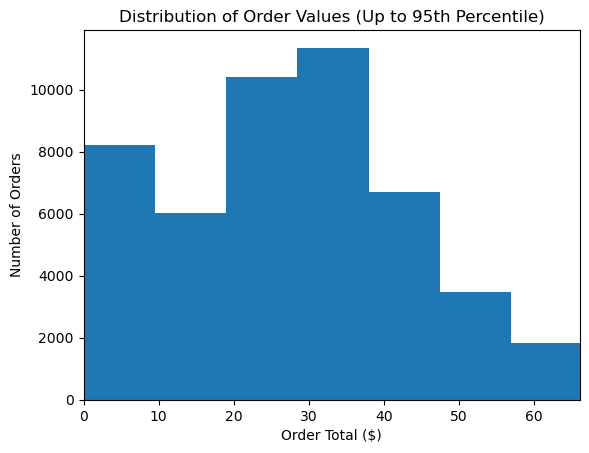

In [17]:
upper_limit = orders_2025["Order Total"].quantile(0.95)

plt.figure()
orders_2025["Order Total"].plot(kind="hist", bins=150)
plt.xlim(0, upper_limit)
plt.title("Distribution of Order Values (Up to 95th Percentile)")
plt.xlabel("Order Total ($)")
plt.ylabel("Number of Orders")
plt.show()

With the x-axis limited to the 95th percentile and increased bin resolution,
the order value distribution reveals a dense concentration of orders in the
$ 15 – $ 45 range, with a gradual right tail extending toward higher values.

The distribution appears continuous rather than multimodal, suggesting that
value-based segmentation should focus on practical thresholds for interpretation
rather than attempting to isolate distinct populations.

## Test Practical Order Value Buckets

In [18]:
orders_2025["value_bucket"] = "mid_value"

orders_2025.loc[orders_2025["Order Total"] < 15, "value_bucket"] = "low_value"
orders_2025.loc[orders_2025["Order Total"] > 45, "value_bucket"] = "high_value"

### Verify Bucket Assignment

In [19]:
orders_2025["value_bucket"].value_counts()

mid_value     30194
low_value     11369
high_value     8924
Name: value_bucket, dtype: int64

### Add Readable Bucket Ranges

In [20]:
orders_2025["value_bucket_range"] = ""

orders_2025.loc[orders_2025["value_bucket"] == "low_value", "value_bucket_range"] = "< $15"
orders_2025.loc[orders_2025["value_bucket"] == "mid_value", "value_bucket_range"] = "$15-$45"
orders_2025.loc[orders_2025["value_bucket"] == "high_value", "value_bucket_range"] = "> $45"

In [21]:
orders_2025["value_bucket_range"] = orders_2025["value_bucket_range"].astype(str)

In [22]:
orders_2025[["value_bucket", "value_bucket_range"]].drop_duplicates()

,value_bucket,value_bucket_range
12119,mid_value,$15-$45
12115,low_value,< $15
12111,high_value,> $45


### Orders per Value Bucket (with Ranges)

In [23]:
orders_per_bucket = orders_2025.groupby(["value_bucket", "value_bucket_range"])["Order ID"].nunique()

### Revenue per Value Bucket

In [24]:
revenue_per_bucket = orders_2025.groupby(["value_bucket", "value_bucket_range"])["Order Total"].sum()

### Average Order Value per Bucket

In [25]:
aov_per_bucket = orders_2025.groupby(["value_bucket", "value_bucket_range"])["Order Total"].mean()

### Combine Bucket Metrics

In [26]:
value_bucket_summary = pd.DataFrame({
    "orders": orders_per_bucket,
    "revenue": revenue_per_bucket,
    "average_order_value": aov_per_bucket
})

value_bucket_summary

,,orders,revenue,average_order_value
value_bucket,value_bucket_range,,,
high_value,> $45,8924,582212.06,65.241154
low_value,< $15,11369,65043.33,5.721113
mid_value,$15-$45,30194,902501.70,29.890101


### Revenue Share by Bucket

In [27]:
value_bucket_summary["revenue_share"] = (
    value_bucket_summary["revenue"] / value_bucket_summary["revenue"].sum()
)

value_bucket_summary

,,orders,revenue,average_order_value,revenue_share
value_bucket,value_bucket_range,,,,
high_value,> $45,8924,582212.06,65.241154,0.37568
low_value,< $15,11369,65043.33,5.721113,0.04197
mid_value,$15-$45,30194,902501.70,29.890101,0.58235


## Segment 1 Interpretation

The value bucket analysis shows that mid- and high-value orders account for the
majority of total revenue, despite representing a smaller share of total orders
relative to low-value purchases.

This suggests that revenue is more sensitive to changes in higher-value orders
than to equivalent changes in low-value order volume. While all value buckets
present growth opportunities, increases in high-value order frequency would
have a disproportionately large impact on overall revenue.

However, the continuous nature of the order value distribution indicates that
value alone is unlikely to define distinct customer populations. As a result,
order value is best used in combination with timing and customer behavior
rather than as a standalone segmentation dimension.

## Segment 2 — Order Timing Segmentation

This segment examines when orders occur to identify temporal patterns
that can inform staffing, promotions, and demand-shaping strategies.

The focus is on:
- Time of day
- Day of week
- Weekend vs weekday behavior


### Orders by Hour

In [28]:
orders_by_hour = orders_2025.groupby("order_hour")["Order ID"].nunique()
orders_by_hour

order_hour
9        5
10     270
11    2543
12    2570
13    2900
14    3381
15    4266
16    5641
17    6443
18    6205
19    5375
20    4669
21    3683
22    2422
23     114
Name: Order ID, dtype: int64

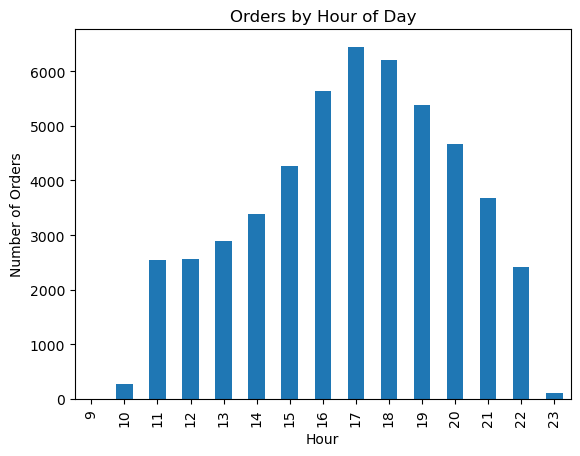

In [29]:
plt.figure()
orders_by_hour.plot(kind="bar")
plt.title("Orders by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Number of Orders")
plt.show()


#### Revenue by Hour

In [30]:
revenue_by_hour = orders_2025.groupby("order_hour")["Order Total"].sum()
revenue_by_hour

order_hour
9        230.70
10      9096.28
11     81458.65
12     75087.09
13     83413.97
14    105797.97
15    135359.93
16    184049.81
17    211024.47
18    202650.63
19    168243.49
20    136369.12
21    101538.71
22     54845.96
23       590.31
Name: Order Total, dtype: float64

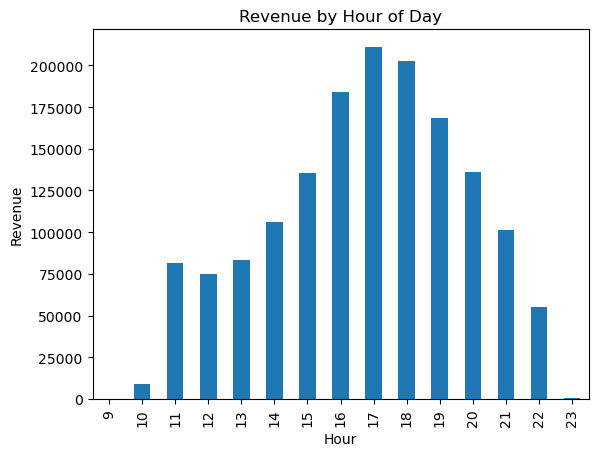

In [31]:
plt.figure()
revenue_by_hour.plot(kind="bar")
plt.title("Revenue by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Revenue")
plt.show()

Hourly order and revenue patterns reveal clear demand peaks and low-activity periods.
These patterns help identify:
- Core operating windows
- Peak demand periods
- Potential off-peak opportunities for activation

### Orders by Day of Week

In [41]:
orders_by_dow = orders_2025.groupby("order_dow")["Order ID"].nunique()
orders_by_dow

order_dow
Friday       9234
Monday       5643
Saturday     8986
Sunday       8457
Thursday     6362
Tuesday      5518
Wednesday    6287
Name: Order ID, dtype: int64

In [42]:
day_order = [
    "Monday", "Tuesday", "Wednesday",
    "Thursday", "Friday", "Saturday", "Sunday"
]

In [43]:
orders_by_dow = orders_by_dow.reindex(day_order)
print(orders_by_dow)

order_dow
Monday       5643
Tuesday      5518
Wednesday    6287
Thursday     6362
Friday       9234
Saturday     8986
Sunday       8457
Name: Order ID, dtype: int64


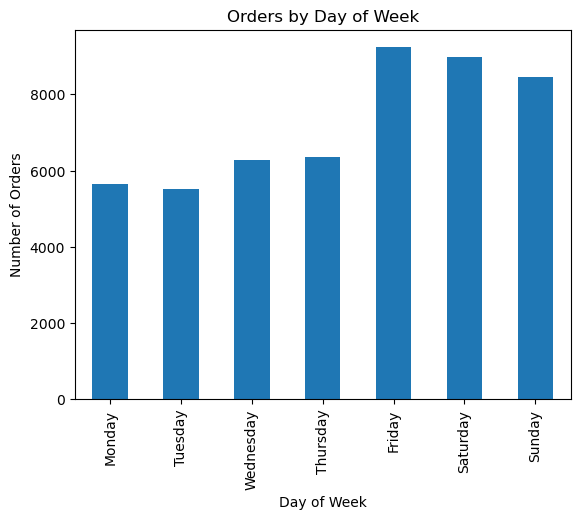

In [44]:
plt.figure()
orders_by_dow.plot(kind="bar")
plt.title("Orders by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Orders")
plt.show()

#### Revenue by Day of Week

In [45]:
revenue_by_dow = orders_2025.groupby("order_dow")["Order Total"].sum()
revenue_by_dow

order_dow
Friday       292212.72
Monday       158169.71
Saturday     295340.98
Sunday       271793.09
Thursday     191166.68
Tuesday      155643.50
Wednesday    185430.41
Name: Order Total, dtype: float64

In [46]:
revenue_by_dow = revenue_by_dow.reindex(day_order)
revenue_by_dow

order_dow
Monday       158169.71
Tuesday      155643.50
Wednesday    185430.41
Thursday     191166.68
Friday       292212.72
Saturday     295340.98
Sunday       271793.09
Name: Order Total, dtype: float64

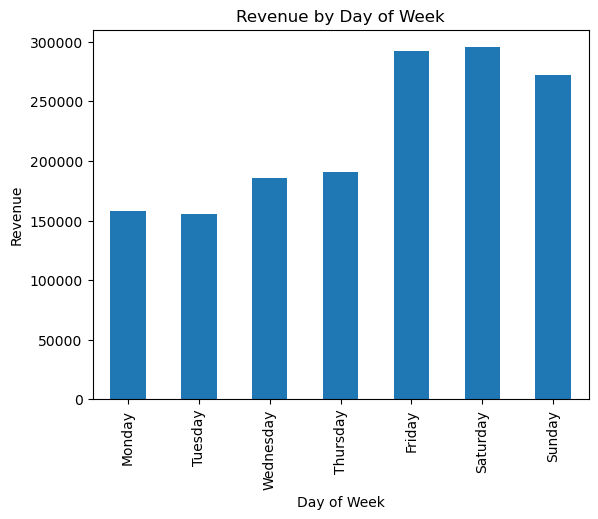

In [47]:
plt.figure()
revenue_by_dow.plot(kind="bar")
plt.title("Revenue by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Revenue")
plt.show()


#### Weekend vs Weekday

In [48]:
orders_2025["day_type"] = "weekday"
orders_2025.loc[orders_2025["is_weekend"], "day_type"] = "weekend"

orders_by_day_type = orders_2025.groupby("day_type")["Order ID"].nunique()
revenue_by_day_type = orders_2025.groupby("day_type")["Order Total"].sum()

orders_by_day_type, revenue_by_day_type

(day_type
 weekday    33044
 weekend    17443
 Name: Order ID, dtype: int64,
 day_type
 weekday    982623.02
 weekend    567134.07
 Name: Order Total, dtype: float64)

Order timing analysis shows strong concentration in specific hours and days,
indicating predictable demand cycles.

These timing-based patterns provide clear opportunities to:
- Reinforce peak-period performance
- Experiment with off-peak promotions
- Align staffing and operational decisions with demand

### Segment 2 Interpretation

Order timing analysis reveals strong and consistent temporal patterns.
Demand increases toward the end of the week, with Friday through Sunday
accounting for the highest order volume and revenue.

Hourly patterns show clear concentration during late afternoon and evening
hours, indicating predictable peak demand windows. In contrast, early-week
and off-peak hours represent lower but potentially activatable demand.

These findings suggest that timing is a primary behavioral segmentation
dimension and should be a key input for staffing, promotions, and
channel-specific outreach strategies.

## Segment 3 — Order Type Interaction

This segment examines how order timing patterns differ by order type.
Rather than analyzing time in aggregate, we break timing behavior down
by order type to understand channel-specific demand patterns.

The focus is on:
- Order type distribution by hour
- Order type differences across weekdays vs weekends

In [49]:
orders_2025["Order Type"].value_counts()

pick up             33733
delivery            11299
in-store pickup      2925
popmenu pickup       1743
popmenu delivery      786
nan                     1
Name: Order Type, dtype: int64

#### Orders by Hour and Order Type

In [50]:
orders_by_hour_type = (
    orders_2025
    .groupby(["order_hour", "Order Type"])["Order ID"]
    .nunique()
)

orders_by_hour_type

order_hour  Order Type      
9           popmenu delivery       2
            popmenu pickup         3
10          delivery              64
            pick up              201
            popmenu delivery       1
                                ... 
22          in-store pickup       28
            pick up             1853
            popmenu delivery      26
            popmenu pickup        44
23          pick up              114
Name: Order ID, Length: 68, dtype: int64

In [51]:
orders_by_hour_type_unstacked = orders_by_hour_type.unstack()
orders_by_hour_type_unstacked

Order Type,delivery,in-store pickup,nan,pick up,popmenu delivery,popmenu pickup
order_hour,,,,,,
9,NaN,NaN,NaN,NaN,2.0,3.0
10,64.0,NaN,NaN,201.0,1.0,4.0
11,511.0,171.0,NaN,1740.0,34.0,87.0
12,437.0,156.0,NaN,1860.0,42.0,75.0
13,566.0,167.0,NaN,2046.0,39.0,82.0
14,705.0,175.0,NaN,2359.0,44.0,98.0
15,960.0,223.0,NaN,2893.0,67.0,123.0
16,1293.0,332.0,NaN,3698.0,87.0,231.0
17,1476.0,374.0,NaN,4237.0,115.0,241.0


<Figure size 640x480 with 0 Axes>

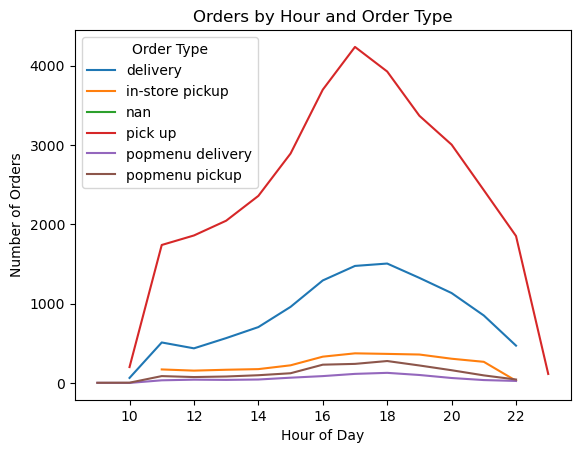

In [52]:
plt.figure()
orders_by_hour_type_unstacked.plot()
plt.title("Orders by Hour and Order Type")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Orders")
plt.show()

#### Revenue by Hour and Order Type

In [53]:
revenue_by_hour_type = (
    orders_2025
    .groupby(["order_hour", "Order Type"])["Order Total"]
    .sum()
)

revenue_by_hour_type_unstacked = revenue_by_hour_type.unstack()
revenue_by_hour_type_unstacked

Order Type,delivery,in-store pickup,nan,pick up,popmenu delivery,popmenu pickup
order_hour,,,,,,
9,NaN,NaN,NaN,NaN,75.45,155.25
10,2906.68,NaN,NaN,5830.05,73.47,286.08
11,20964.63,6527.47,NaN,47594.37,2789.59,3582.59
12,17666.10,4934.31,NaN,47905.03,1798.56,2783.09
13,22644.91,5341.58,NaN,50798.83,1708.93,2919.72
14,31079.08,5893.81,NaN,62905.24,2294.80,3625.04
15,41028.12,8075.66,NaN,77982.30,3037.83,5236.02
16,54327.65,12330.93,NaN,103487.01,4010.61,9893.61
17,60731.42,13175.71,NaN,121861.77,5125.28,10130.29


<Figure size 640x480 with 0 Axes>

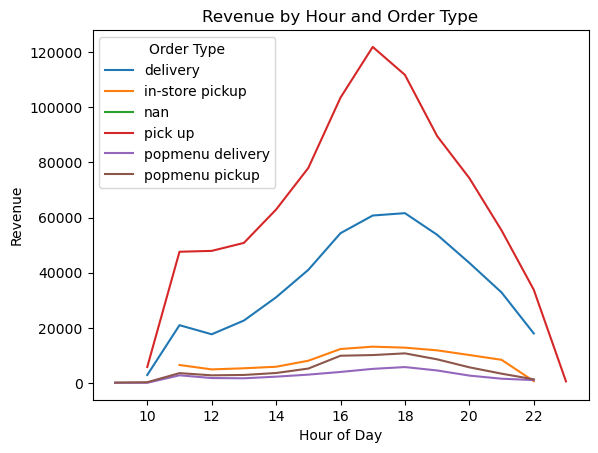

In [54]:
plt.figure()
revenue_by_hour_type_unstacked.plot()
plt.title("Revenue by Hour and Order Type")
plt.xlabel("Hour of Day")
plt.ylabel("Revenue")
plt.show()

#### Weekday vs Weekend × Order Type

In [55]:
orders_by_daytype_ordertype = (
    orders_2025
    .groupby(["day_type", "Order Type"])["Order ID"]
    .nunique()
)

orders_by_daytype_ordertype

day_type  Order Type      
weekday   delivery             7280
          in-store pickup      1867
          nan                     1
          pick up             22320
          popmenu delivery      494
          popmenu pickup       1082
weekend   delivery             4019
          in-store pickup      1058
          pick up             11413
          popmenu delivery      292
          popmenu pickup        661
Name: Order ID, dtype: int64

In [56]:
orders_by_daytype_ordertype_unstacked = orders_by_daytype_ordertype.unstack()
orders_by_daytype_ordertype_unstacked

Order Type,delivery,in-store pickup,nan,pick up,popmenu delivery,popmenu pickup
day_type,,,,,,
weekday,7280.0,1867.0,1.0,22320.0,494.0,1082.0
weekend,4019.0,1058.0,NaN,11413.0,292.0,661.0


<Figure size 640x480 with 0 Axes>

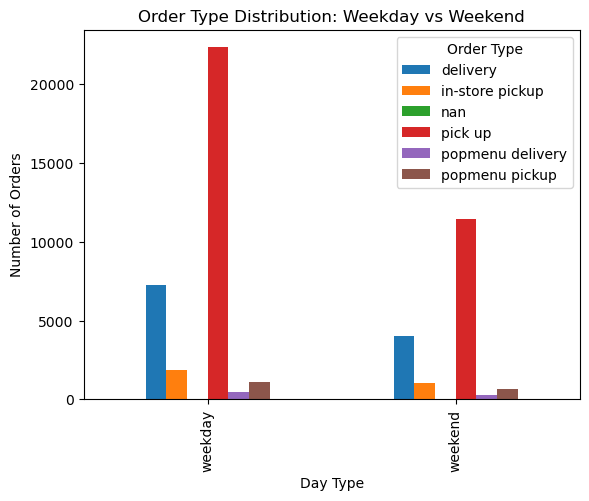

In [57]:
plt.figure()
orders_by_daytype_ordertype_unstacked.plot(kind="bar")
plt.title("Order Type Distribution: Weekday vs Weekend")
plt.xlabel("Day Type")
plt.ylabel("Number of Orders")
plt.show()

### Segment 3 Interpretation

Order type interaction analysis shows that demand timing is not uniform
across order types. Certain order types dominate specific hours of the day,
and the mix of order types differs meaningfully between weekdays and weekends.

These patterns suggest that order timing and order type should be treated
as interacting dimensions rather than analyzed independently. Channel-specific
strategies may benefit from aligning promotions and messaging with the
dominant order type during peak periods.

Order type interaction analysis shows that pickup dominates demand across all
time windows, particularly during late afternoon and evening peak hours.
Other order types follow similar temporal patterns but contribute at lower
overall volume and revenue levels.

Revenue trends closely mirror order volume across order types, indicating that
timing-based revenue changes are primarily driven by order frequency rather than
differences in average order value by channel.

Weekend demand represents an amplification of existing weekday behavior rather
than a shift in order type mix. These findings suggest that pickup-focused,
time-aware strategies offer the greatest opportunity for growth, particularly
during peak demand periods.

### Phase 4 — Order-Level Segmentation Summary

Across value, timing, and order type analyses, order-level behavior shows strong
consistency in how demand is generated.

Revenue growth is primarily driven by order frequency concentrated during
predictable peak hours and days, with pickup orders dominating volume and revenue
across all time windows. Order value contributes to revenue amplification but does
not define distinct behavioral groups on its own.

These findings suggest that customer segmentation should focus on differences in
ordering frequency, recency, and timing sensitivity rather than assumed differences
in spend per order.


## Segment 4 — Order-Level Behavioral Personas

Due to the absence of a shared customer identifier between orders and the
available customer table, segmentation at the individual customer level
is not possible.

Instead, this segment synthesizes prior findings into order-level behavioral
personas that approximate customer behavior without assuming individual tracking.
These personas represent recurring patterns in how, when, and why orders occur.


### Order-Level Behavioral Personas

**1. Weekend Dinner Pickup Orders**  
High-volume pickup orders concentrated on Friday through Sunday evenings.
These orders drive a significant share of total revenue and represent the
core demand period for the business.

**2. Weekday Core Orders**  
Moderate-value pickup orders occurring during weekday lunch and early
dinner hours. This segment provides consistent baseline volume and
represents an opportunity for frequency-based growth.

**3. High-Value Evening Orders**  
Orders with higher-than-average value concentrated during evening hours.
Although smaller in volume, these orders contribute disproportionately
to revenue and may reflect group or family purchases.

**4. Off-Peak Low-Value Orders**  
Lower-value orders occurring during early-week or off-peak hours.
While individually small, this segment represents potential demand
that could be activated through timing-based promotions.

### Strategy Implications by Persona

- **Weekend Dinner Pickup Orders**  
  Focus on operational efficiency, staffing alignment, and order throughput
  rather than demand creation.

- **Weekday Core Orders**  
  Target with frequency-based incentives and reminders to increase repeat
  ordering during predictable windows.

- **High-Value Evening Orders**  
  Protect and enhance through bundle optimization and upsell opportunities,
  particularly during peak dinner hours.

- **Off-Peak Low-Value Orders**  
  Consider time-specific promotions or messaging to shift demand into
  underutilized periods.

## Phase 4 Summary

Phase 4 transitioned from descriptive analysis to behavioral segmentation by
examining order value, timing, and order type interactions. Results show that
revenue is primarily driven by order frequency concentrated during predictable
peak periods, with pickup orders dominating across all time windows.

Although customer-level segmentation was not possible due to data limitations,
order-level personas provide actionable insights that can inform timing-based
promotions, pickup-focused strategies, and operational planning.

This phase establishes a strong behavioral foundation for future analyses,
including demand forecasting or experimentation with targeted interventions.
